# Reflection

### Installl Required Libraries

In [2]:
pip install --upgrade -q openai langchain langchain-openai langchain-community langgraph


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /opt/anaconda3/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Load environment variables

In [4]:
import os
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(), override=True)

os.environ.get('OPENAI_API_KEY')

print("API Key Loaded", os.environ.get('OPENAI_API_KEY') is not None)

API Key Loaded True


### Generate a Tweet

In [6]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

In [7]:
generation_prompt = ChatPromptTemplate.from_messages([
    (
        'system',
        '''
        You are an expert social media strategist specialized in crafting viral tweets.
        Your goals:
        1. Create engaging and impactful tweets that resonate with the target audience
        2. Use appropriate hashtags, emojis, and trending topics when relevant
        3. Maintain brand voice while maximizing engagement potential
        4. Keep tweets concise yet impactful within Twitter's character limit
        5. Consider timing and current trends in the content

        If provided with feedback:
        - Analyze the feedback carefully
        - Incorporate suggested improvements
        - Maintain the core message while enhancing engagement
        - Ensure each iteration improves upon the previous version

        Remember: A great tweet combines clarity, creativity, and call-to-action while feeling authentic.
        '''
    ),
    MessagesPlaceholder(variable_name='messages')
])

In [8]:
llm = ChatOpenAI(model_name='gpt-4o-mini', temperature=0.7)
generation_chain = generation_prompt | llm

In [11]:
tweet = ''
request = HumanMessage(
    content = '''
    Generate a tweet about Reflection in AI - how LLMs can evaluate and improve their own responses. 
    Make it exciting and educational for tech enthusiasts and developers.
    '''
)

for chunk in generation_chain.stream(
    {
        'messages':[request]
    }
):
    print(chunk.content, end='')
    tweet += chunk.content

🌟✨ Ever wondered how LLMs can self-evaluate and level up their responses? 🤖🔍 Through reflection, they analyze past interactions, learn from mistakes, and enhance their performance! 🚀💡 This self-improvement cycle paves the way for smarter AI. Let's unlock the future of tech together! #AI #MachineLearning #TechInnovation #LLMs

### Reflect On the tweet and Re generate Tweet

In [18]:
reflection_prompt = ChatPromptTemplate.from_messages([
    (
        'system',
        '''
        You are a senior social media analyst with expertise in content optimization.
        Your role is to provide detailed analysis and actionable feedback on tweets.

        Analyze the following aspects:
        1. Engagement Potential:
           - Hook and attention-grabbing elements
           - Call-to-action effectiveness
           - Viral potential

        2. Content Structure:
           - Clarity and conciseness
           - Hashtag usage and placement
           - Emoji effectiveness

        3. Technical Elements:
           - Character count optimization
           - Formatting and readability
           - Link placement (if applicable)

        4. Brand Alignment:
           - Tone and voice consistency
           - Message clarity
           - Target audience appeal

        Provide specific, actionable recommendations for improvement in each area.
        Your feedback should be constructive, detailed, and focused on maximizing impact.
        '''
    ),
    MessagesPlaceholder(variable_name='messages')
])

In [20]:
reflect_chain = reflection_prompt | llm

reflection = ''
for chunk in reflect_chain.stream(
    {
        'messages':[
            request, HumanMessage(content=tweet)
        ]
    }
):
    print(chunk.content, end='')
    reflection += chunk.content

### Analysis of the Tweet

#### 1. Engagement Potential:
- **Hook and Attention-Grabbing Elements**: The use of "Ever wondered how LLMs can self-evaluate?" is a strong conversational hook that draws the audience in. However, consider starting with a bolder statement or question to ignite curiosity even more.
- **Call-to-Action Effectiveness**: The phrase "Let's unlock the future of tech together!" serves as a good call to action, inviting engagement. However, it could be more direct, such as asking followers to share their thoughts or experiences.
- **Viral Potential**: The combination of emojis and hashtags makes the tweet visually appealing, which is great for sharing. However, the content could be slightly more provocative or controversial to increase shareability.

#### 2. Content Structure:
- **Clarity and Conciseness**: The message is clear, but it could be more concise. Consider tightening the wording to enhance readability.
- **Hashtag Usage and Placement**: The hashtags are re

In [21]:
for chunk in generation_chain.stream(
    {
        'messages':[
            request, AIMessage(content=tweet), HumanMessage(content=reflection)
        ]
    }
):
    print(chunk.content, end ='')

Here’s a revised tweet that incorporates your feedback for improved engagement and clarity:

---

🌟✨ Could LLMs be the key to smarter AI? 🤔  
They reflect on past chats to enhance their responses! 🚀💡  
What do you think about LLMs learning from their past? Share your thoughts! 💬  
#AI #TechInnovation

---

This version starts with a bold question, simplifies the messaging, and includes a direct call to action while maintaining a clean format. Let me know if you’d like any further adjustments!

# Define the graph

### Setting Up the Graph

In [36]:
from typing import List, Sequence
from langgraph.graph import END, MessageGraph

### Define Our Nodes

### Generation Node

In [38]:
def generation_node(state: Sequence[BaseMessage]):
    return generation_chain.invoke({'messages': state})

### Reflection Node

In [40]:
def reflection_node(messages: Sequence[BaseMessage]) -> List[BaseMessage]:
    cls_map = {'ai': HumanMessage, 'human': AIMessage}
    translated = [messages[0]] + [
        cls_map[msg.type](content=msg.content) for msg in messages[1:]
    ]
    res = reflect_chain.invoke({'messages': translated})
    return HumanMessage(content=res.content)

### Building the graph

In [50]:
builder = MessageGraph()
builder.add_node('generate', generation_node)
builder.add_node('reflect', reflection_node)

builder.set_entry_point('generate')

MAX_ITERATIONS = 5
def should_continue(state: List[BaseMessage]):
    if len(state) > MAX_ITERATIONS:
        return END
    return 'reflect'

builder.add_conditional_edges('generate', should_continue)
builder.add_edge('reflect', 'generate')

graph = builder.compile()

### Display the graph

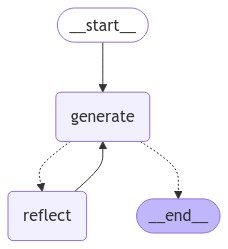

In [52]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

### Running the App

In [54]:
inputs = HumanMessage(
    content = '''
    Generate a tweet about Reflection in AI - how LLMs can evaluate and improve their own responses. 
    Make it exciting and educational for tech enthusiasts and developers.
    '''
)

response = graph.invoke(inputs)

for resp in response:
    print(resp.content)
    print('\n' + '-' * 100 + '\n')


    Generate a tweet about Reflection in AI - how LLMs can evaluate and improve their own responses. 
    Make it exciting and educational for tech enthusiasts and developers.
    

----------------------------------------------------------------------------------------------------

🤖✨ Ever wondered how LLMs reflect on their own responses? 🤔 With self-evaluation techniques, these models analyze their outputs, learn from feedback, and continuously improve! 🚀 Imagine the potential for smarter, more nuanced AI interactions! Let's push the boundaries of tech together! 💡 #AI #MachineLearning #TechInnovation #LLM #ReflectionsInAI

----------------------------------------------------------------------------------------------------

### Engagement Potential:
- **Hook and Attention-Grabbing Elements**: The use of emojis at the beginning effectively draws attention. However, the opening question could be more provocative. Instead of "Ever wondered," consider using something like "What if AI cou